In [1]:
%load_ext nb_black
# !pip install nb_black

<IPython.core.display.Javascript object>

In [2]:
# this prediction model tires to model the current year feature values with the next year's class value
# with out any prediction for the feature values
# smotenc added

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
randomseed = 7

Using TensorFlow backend.


<IPython.core.display.Javascript object>

1 Read dataset
===

In [4]:
x_original = pd.read_csv("../dataset/XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original = x_original[
    [
        "Unnamed: 0",
        "L100800",
        "L104600",
        "S000300",
        "AGE",
        "SEX",
        "FIELD_16",
        "FIELD_23",
        "FIELD_15",
        "FIELD_22",
        "FIELD_17",
        "FIELD_24",
    ]
]

<IPython.core.display.Javascript object>

In [5]:
y_original = pd.read_csv("../dataset/TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original = y_original[["Unnamed: 0", "CLASS"]]

<IPython.core.display.Javascript object>

In [6]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

<IPython.core.display.Javascript object>

In [7]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia


print(data.shape)

(169024, 13)


<IPython.core.display.Javascript object>

In [8]:
data = data.dropna()
print(data.shape)
data = data[["L100800", "L104600", "S000300", "AGE", "SEX", "CLASS"]]
data.head()

(60035, 13)


,L100800,L104600,S000300,AGE,SEX,CLASS
2,78.0,5.28,20.2,46.0,1.0,0
5,90.0,5.74,25.5,52.0,1.0,0
10,86.0,5.83,21.2,37.0,1.0,0
11,86.0,4.73,22.0,39.0,1.0,0
20,87.0,5.60,24.6,59.0,1.0,0


<IPython.core.display.Javascript object>

In [9]:
data.groupby(by="CLASS").size()

CLASS
0    40171
1    18708
2     1156
dtype: int64

<IPython.core.display.Javascript object>

2.Downsample the majority class and upsample the minority
===

In [10]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

1156 18708 40171


<IPython.core.display.Javascript object>

In [11]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index)
# .sample(
#     10 * diabetic_train.shape[0], random_state=randomseed
# )
normal_train = normal.drop(normal_test.index).sample(
    prediabetic_train.shape[0],
    random_state=randomseed
    #     10 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

<IPython.core.display.Javascript object>

In [12]:
xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]

<IPython.core.display.Javascript object>

In [13]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)


<IPython.core.display.Javascript object>

In [14]:
from imblearn.over_sampling import SMOTE,SMOTENC  # doctest: +NORMALIZE_WHITESPACE
randomseed=42

sm = SMOTENC(random_state=randomseed,categorical_features=[4],sampling_strategy='minority')
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res


Resampled dataset shape Counter({2: 18508, 1: 18508, 0: 18508})
18508 18508 18508
(55524, 5) (55524,)


<IPython.core.display.Javascript object>

3.Classifiers
===

3.1.Random Forest
===

In [15]:
parameters = {
    "max_features": ("auto", "sqrt", "log2"),
    "n_estimators": [10, 50, 100, 150, 200, 300, 700],
}
rf_clf = RandomForestClassifier()
rf_clf = GridSearchCV(rf_clf, parameters)
rf_clf.fit(xtrain, ytrain)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

<IPython.core.display.Javascript object>

In [16]:
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

In [17]:
rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

# rf=rf_clf.best_estimator_
# rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features='sqrt', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=700,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)


rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

In [18]:
from sklearn import model_selection

scores = model_selection.cross_val_score(rf, xtrain, ytrain, cv=10, scoring="accuracy")
print(
    "Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]"
    % (scores.mean(), scores.std(), "RandomForestClassifier", scores)
)

Accuracy: 0.74 (+/- 0.04) [RandomForestClassifier] 
 [[0.63353142 0.71745003 0.7334774  0.76463173 0.76481181 0.76427156
 0.74338196 0.73113632 0.75981982 0.75297297]]


<IPython.core.display.Javascript object>

0.735


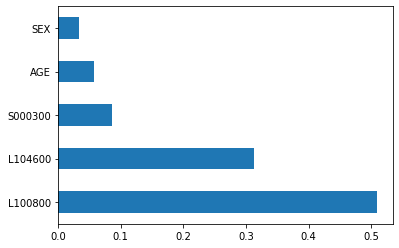

Index(['L100800', 'L104600', 'S000300', 'AGE', 'SEX'], dtype='object')


<IPython.core.display.Javascript object>

In [19]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [20]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.792
Accuracy on test set: 0.735


,0,1,2
0,135,65,0
1,51,136,13
2,2,28,170


<IPython.core.display.Javascript object>

In [21]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       200
           1       0.59      0.68      0.63       200
           2       0.93      0.85      0.89       200

    accuracy                           0.73       600
   macro avg       0.75      0.73      0.74       600
weighted avg       0.75      0.73      0.74       600



<IPython.core.display.Javascript object>

3.2.XGBoost
===

In [22]:
parameters = {"max_depth": [3, 5, 7, 9], "n_estimators": [10, 50, 100, 200, 700]}
xgb_clf = xgb.XGBClassifier()
xgb_clf = GridSearchCV(xgb_clf, parameters)
xgb_clf.fit(xtrain, ytrain)
xgb_clf.best_estimator_

NameError: name 'xgb' is not defined

<IPython.core.display.Javascript object>

In [ ]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="multi:soft", random_state=randomseed)

xgb_model.fit(xtrain, ytrain)


In [ ]:
from sklearn import model_selection
scores = model_selection.cross_val_score(xgb_model, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'xgb_model',scores))

In [ ]:
y_pred = xgb_model.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

3.3 SVC
===

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,15,20,25,30,70]}
SVC_clf = SVC()
SVC_clf2 = GridSearchCV(SVC_clf, parameters)
SVC_clf2.fit(xtrain, ytrain)


# sorted(SVC_clf2.cv_results_.keys())

In [ ]:
SVC_clf2.best_estimator_

In [ ]:
# SVC_clf = SVC_clf2.best_estimator_
SVC_clf = SVC(
    C=30,
    cache_size=200,
    class_weight=None,
    coef0=0.0,
    decision_function_shape="ovr",
    degree=3,
    gamma="auto_deprecated",
    kernel="linear",
    max_iter=-1,
    probability=False,
    random_state=randomseed,
    shrinking=True,
    tol=0.001,
    verbose=False,
)
SVC_clf.fit(xtrain, ytrain)

In [ ]:
from sklearn import model_selection
scores = model_selection.cross_val_score(SVC_clf, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'SVC_clf',scores))

In [ ]:
y_pred = SVC_clf.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

3.4Logistic regression
===

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(xtrain, ytrain)

In [ ]:
y_pred = lr.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

3.5 K-neighbors Classifier
===

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=150)
neigh.fit(xtrain, ytrain)

In [ ]:
y_pred = neigh.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

4.StackingClassifier
===

In [ ]:
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier

estimators = [rf, xgb_model, SVC_clf, lr, neigh]
stcl = StackingClassifier(
    classifiers=estimators,
    verbose=2,
    meta_classifier=SVC(random_state=randomseed)
    #     meta_classifier=xgb.XGBClassifier(
    #         objective="multi:softmax", random_state=randomseed,n_estimators=100
    #     )
    #     meta_classifier=RandomForestClassifier(n_estimators=10, random_state=42),
)

In [ ]:
print("10-fold cross validation:\n")

for clf, label in zip(
    [rf, xgb_model, SVC_clf, lr, neigh],
    ["rf", "xgb_model", "SVC_clf", "lr", "Kneigh", "StackingClassifier"],
):

    scores = model_selection.cross_val_score(
        clf, xtrain, ytrain, cv=10, scoring="accuracy"
    )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
scores = model_selection.cross_val_score(
    stcl, xtrain, ytrain, cv=10, scoring="accuracy"
)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
stcl.fit(xtrain, ytrain)

In [ ]:
y_pred = stcl.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print(classification_report(ytest, y_pred))

In [ ]:
y_pred = stcl.clfs_[4].predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
# multi-class classification with Keras
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
# create model
model = Sequential()
model.add(Dense(64, input_dim=11, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, kernel_initializer='normal', activation='linear'))


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, xtrain, ytrain, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history=model.fit(xtrain, np_utils.to_categorical( ytrain.to_numpy()), 
                  epochs=100, batch_size=10,validation_split=.2)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# =====================================

tempdata=data5

diabetic = tempdata[tempdata.CLASS == 2]
prediabetic = tempdata[tempdata.CLASS == 1].sample(diabetic.shape[0],random_state=0)
normal = tempdata[tempdata.CLASS == 0].sample(diabetic.shape[0],random_state=0)

tempdata5=pd.concat([diabetic,prediabetic,normal])
tempdata5.iloc[:, 3:-2]=scaler.transform(tempdata5.iloc[:, 3:-2])

pred5 = rf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
#xgboost test

In [ ]:
tempdata5Rcolumns=tempdata5.iloc[:, 3:-2]
tempdata5Rcolumns.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
pred5 = xgb_model.predict((tempdata5Rcolumns))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))


In [ ]:
#SVC

In [ ]:
pred5 = SVC_clf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
# ========================================================

In [ ]:
# import pickle

# with open('_DiabeticClassifierModelForNextYear_rf_model', 'wb') as f:
#     pickle.dump(rf, f)

In [ ]:
# with open('_DiabeticClassifierModelForNextYear_scaler', 'wb') as f:
#     pickle.dump(scaler, f)